##### Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from sklearn.cluster import KMeans
import csv


#### Load in the data & clean it up

In [2]:
data = pd.read_csv("data/numerical_data.csv")

# replace null/missing values in each column with column averages
data.fillna(data.mean(), inplace=True)

# drop 'index' column
data.drop(columns=['index'], inplace=True, errors='ignore')
print(data.shape[1])

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

45


#### Perform DBSCAN using all features (evaluate general performance as a starting point)

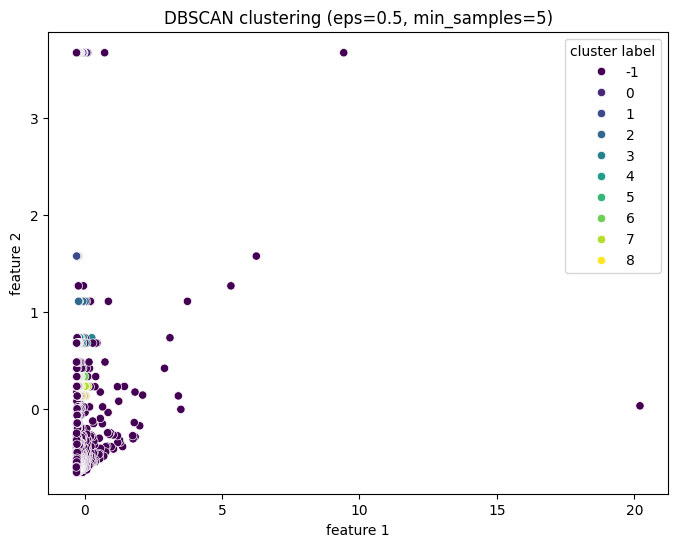

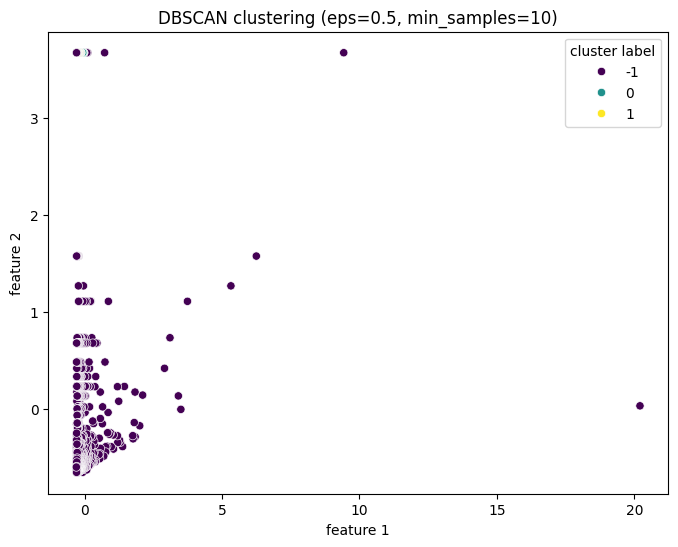

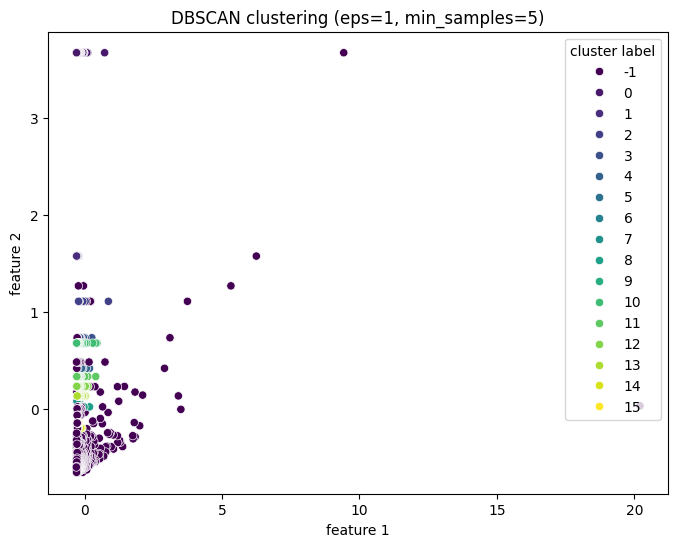

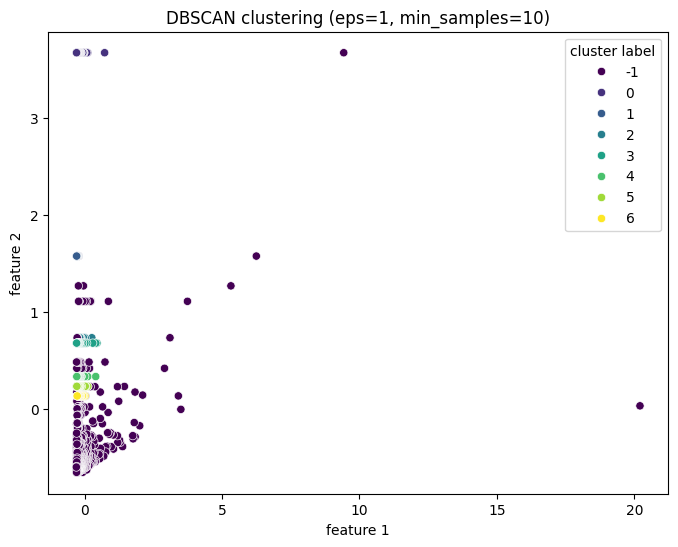

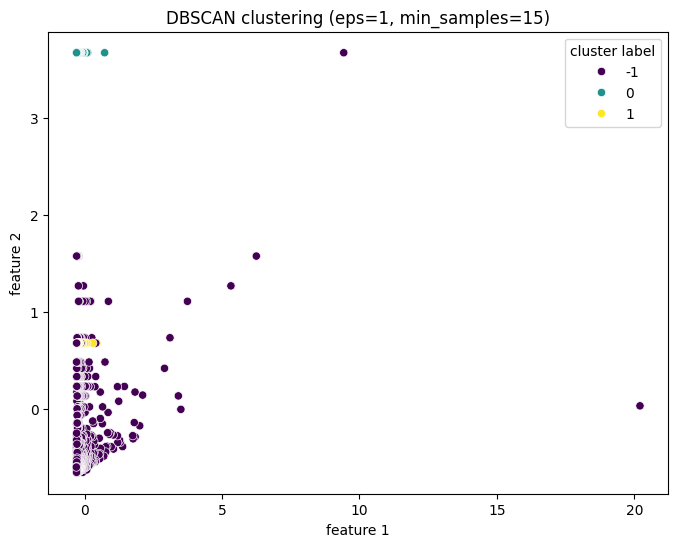

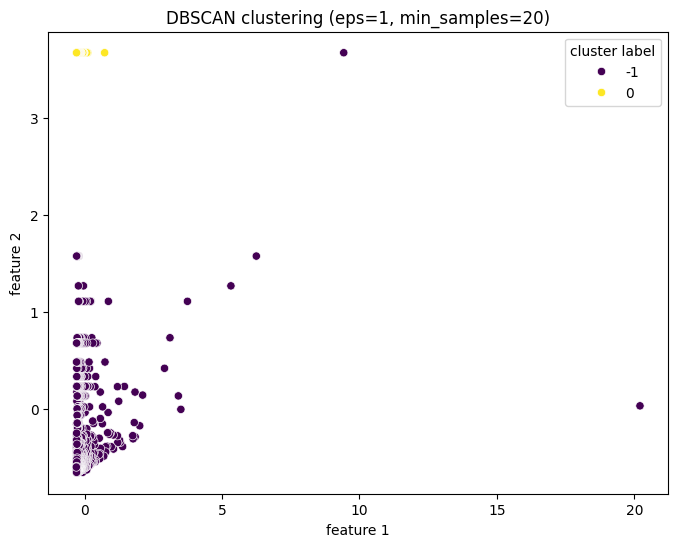

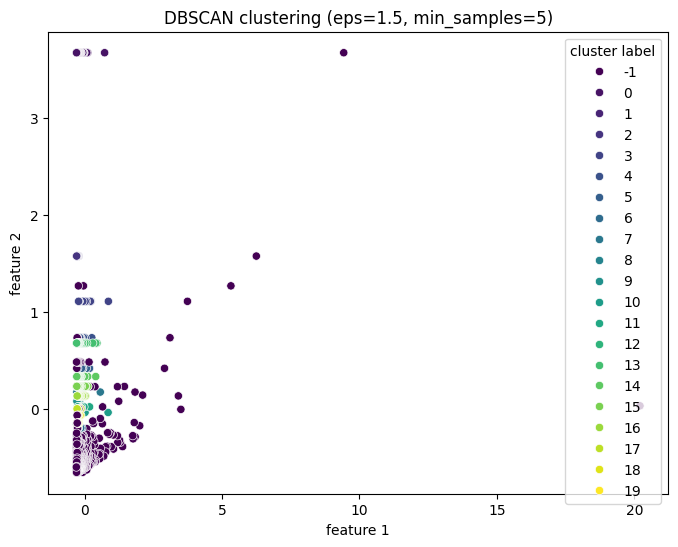

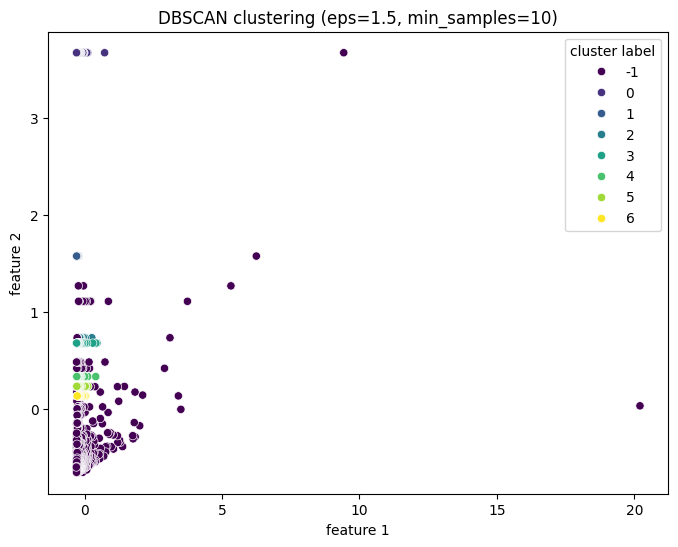

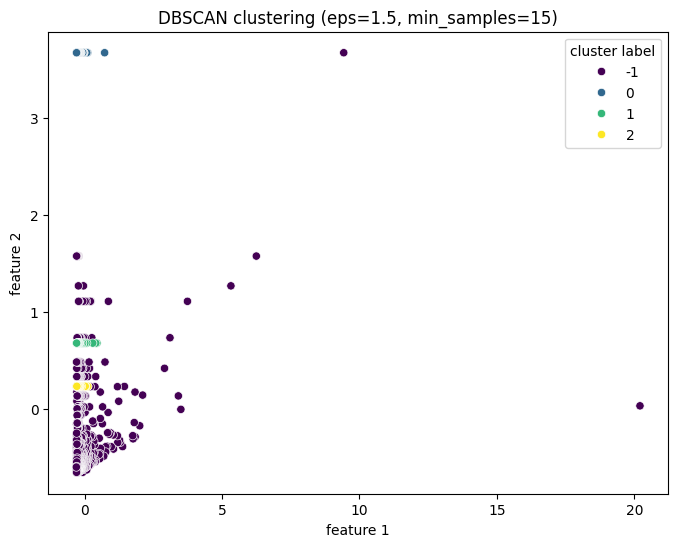

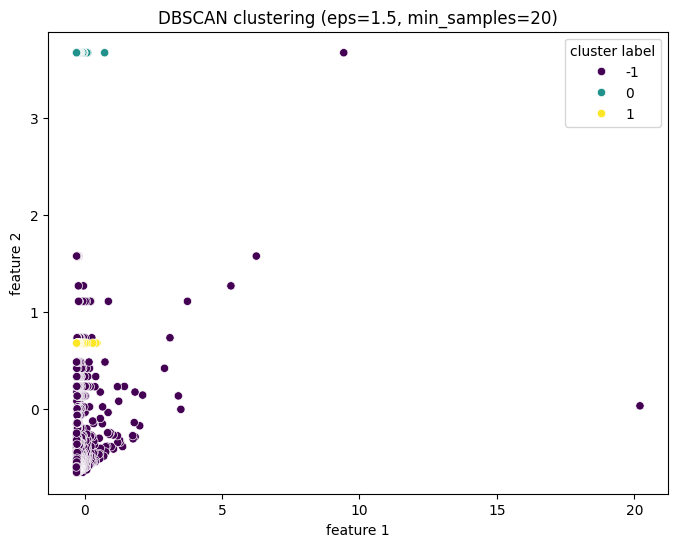

Best silhouette score: 0.03555240990895669
Best eps: 1
Best min_samples: 20


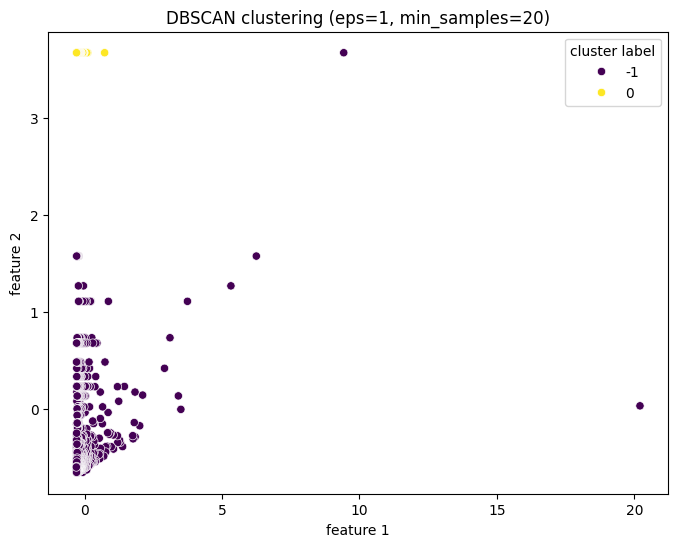

   city_population  county_population  density    pct_men  pct_women  \
0          8336817            1653877    10715  47.291425  52.708575   
1          3979576           10105722     3276  49.275460  50.724540   
2           462628           10105722     3523  49.275460  50.724540   
3           212979           10105722     1162  49.275460  50.724540   
4           199303           10105722     2525  49.275460  50.724540   

   pct_hispanic  pct_white  pct_black  pct_native  pct_asian  ...  \
0          26.1       46.8       12.5         0.1       11.9  ...   
1          48.4       26.5        7.9         0.2       14.3  ...   
2          48.4       26.5        7.9         0.2       14.3  ...   
3          48.4       26.5        7.9         0.2       14.3  ...   
4          48.4       26.5        7.9         0.2       14.3  ...   

   LTM_min_temp  LTM_max_temp  age29andunder_pct  age65andolder_pct  \
0          48.6          64.1          36.439695          14.383705   
1         

In [32]:
# def different vals of eps & min_samples
eps_values = [0.1, 0.5, 1, 1.5]
min_samples = [5, 10, 15, 20]
best_silhouette_score = -1

for eps in eps_values:
    for ms in min_samples:
        # create and fit DBSCAN model
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        dbscan.fit(X_scaled)

        # check num clusters > 1
        if len(np.unique(dbscan.labels_)) < 2:
            continue

        sscore = silhouette_score(X_scaled, dbscan.labels_)
        if sscore > best_silhouette_score:
            best_silhouette_score = sscore
            best_eps = eps
            best_min_samples = ms

        # visualize clusters
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=dbscan.labels_, palette='viridis', legend='full')
        plt.title(f'DBSCAN clustering (eps={eps}, min_samples={ms})')
        plt.xlabel('feature 1')
        plt.ylabel('feature 2')
        plt.legend(title='cluster label', loc='upper right')
        plt.show()

# print best hyperparameters and plot
print(f'Best silhouette score: {best_silhouette_score}')
print(f'Best eps: {best_eps}')
print(f'Best min_samples: {best_min_samples}')
# plot
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=dbscan.labels_, palette='viridis', legend='full')
plt.title(f'DBSCAN clustering (eps={best_eps}, min_samples={best_min_samples})')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(title='cluster label', loc='upper right')
plt.show()


print(data.head())


#### Visualize DBSCAN clustering: city_population, avg_income, mean_commute

/var/folders/jn/ggpyvhb57cl2wckyvdwkqvqh0000gn/T/ipykernel_53060/2522980279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(X_train.mean(), inplace=True)


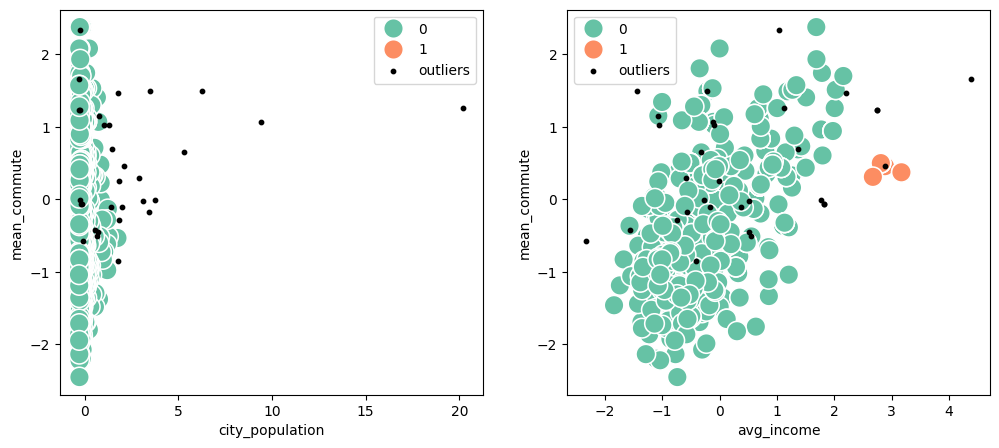

In [33]:
X_train = data[['city_population', 'avg_income', 'mean_commute']]

# replace missing values with avg of each column
X_train.fillna(X_train.mean(), inplace=True)

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_scaled, columns=X_train.columns)

# create DBSCAN clusters
clustering = DBSCAN(eps=0.5, min_samples=5).fit(X_train)
DBSCAN_dataset = X_train.copy()
DBSCAN_dataset['cluster'] = clustering.labels_

# plot!
fig2, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot 1
sns.scatterplot(x='city_population', y='mean_commute',
                data=DBSCAN_dataset[DBSCAN_dataset['cluster'] != -1],
                hue='cluster', ax=axes[0], palette='Set2', legend='full', s=200)
axes[0].scatter(DBSCAN_dataset.loc[DBSCAN_dataset['cluster'] == -1, 'city_population'], 
                DBSCAN_dataset.loc[DBSCAN_dataset['cluster'] == -1, 'mean_commute'], 
                s=10, label='outliers', c="k")
axes[0].legend()

# plot 2
sns.scatterplot(x='avg_income', y='mean_commute',
                data=DBSCAN_dataset[DBSCAN_dataset['cluster'] != -1],
                hue='cluster', palette='Set2', ax=axes[1], legend='full', s=200)
axes[1].scatter(DBSCAN_dataset.loc[DBSCAN_dataset['cluster'] == -1, 'avg_income'], 
                DBSCAN_dataset.loc[DBSCAN_dataset['cluster'] == -1, 'mean_commute'], 
                s=10, label='outliers', c="k")
axes[1].legend()

plt.show()

#### Visualize DBSCAN: no metric, using mean_temperature, avg_property_tax, crime_rate


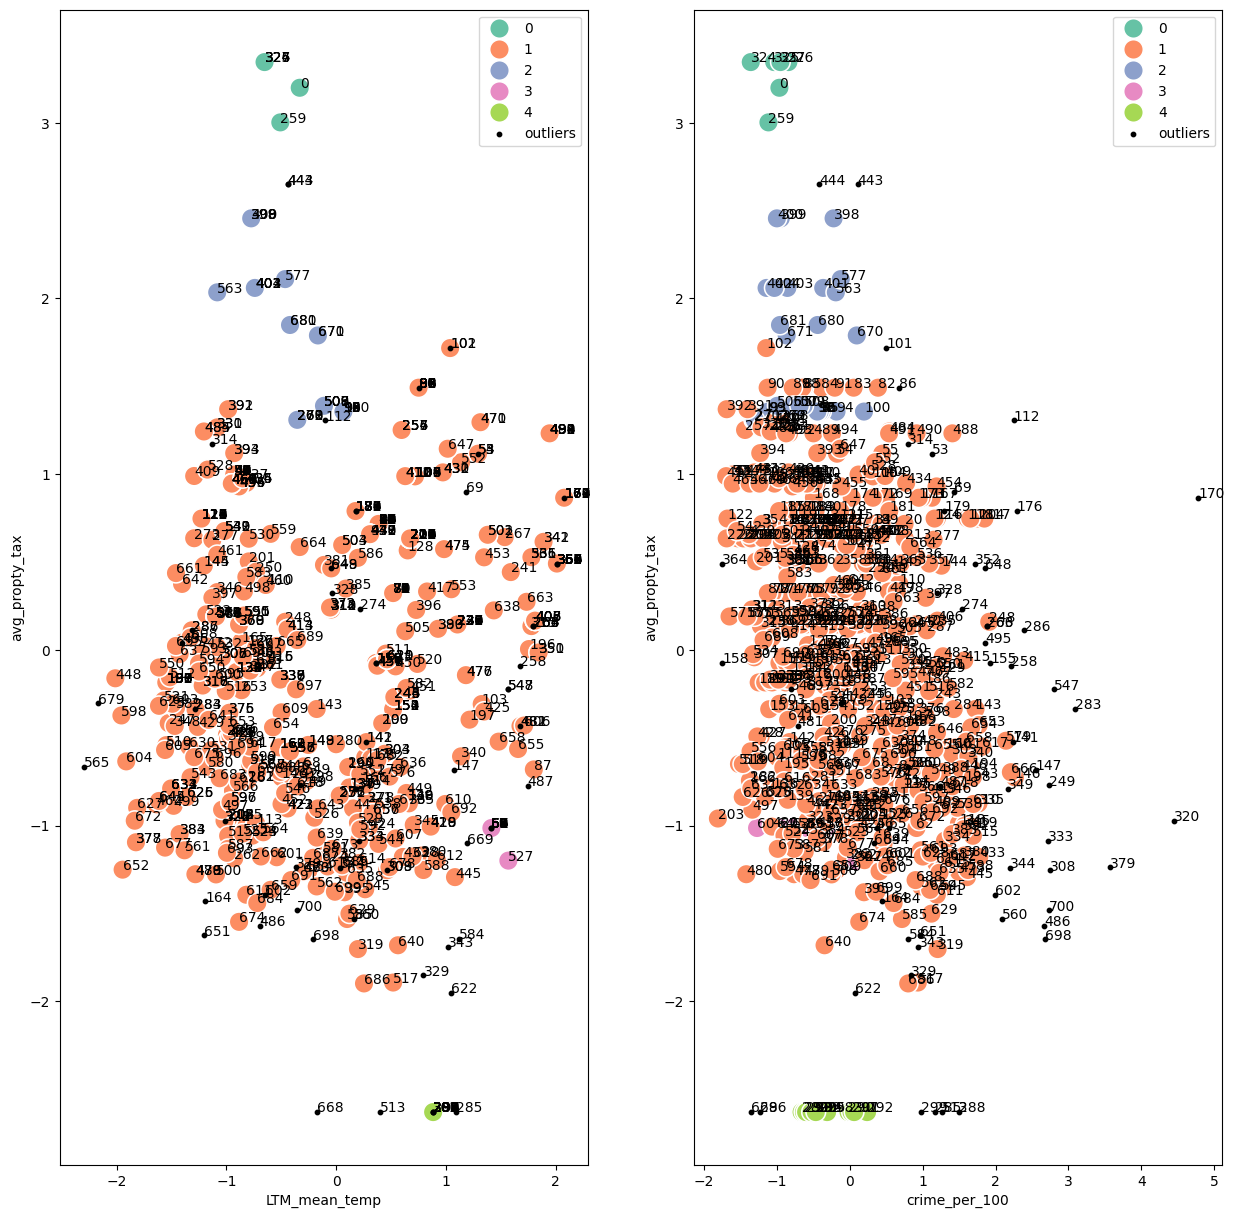

In [34]:
features = ['LTM_mean_temp', 'avg_propty_tax', 'crime_per_100']

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])
X_train = pd.DataFrame(X_scaled, columns=features)

# create DBSCAN clusters
clustering = DBSCAN(eps=0.5, min_samples=5).fit(X_train)
DBSCAN_dataset = X_train.copy()
DBSCAN_dataset['cluster'] = clustering.labels_

# plot each
fig2, axes = plt.subplots(1, 2, figsize=(15, 15))

# plot 1
sns.scatterplot(x='LTM_mean_temp', y='avg_propty_tax',
                data=DBSCAN_dataset[DBSCAN_dataset['cluster'] != -1],
                hue='cluster', ax=axes[0], palette='Set2', legend='full', s=200)
axes[0].scatter(DBSCAN_dataset.loc[DBSCAN_dataset['cluster'] == -1, 'LTM_mean_temp'],
                DBSCAN_dataset.loc[DBSCAN_dataset['cluster'] == -1, 'avg_propty_tax'],
                s=10, label='outliers', c="k")
axes[0].legend()

# plot 2
sns.scatterplot(x='crime_per_100', y='avg_propty_tax',
                data=DBSCAN_dataset[DBSCAN_dataset['cluster'] != -1],
                hue='cluster', palette='Set2', ax=axes[1], legend='full', s=200)
axes[1].scatter(DBSCAN_dataset.loc[DBSCAN_dataset['cluster'] == -1, 'crime_per_100'],
                DBSCAN_dataset.loc[DBSCAN_dataset['cluster'] == -1, 'avg_propty_tax'],
                s=10, label='outliers', c="k")
axes[1].legend()

# label data points by city not index
for i, txt in enumerate(DBSCAN_dataset.index):
    axes[0].annotate(txt, (DBSCAN_dataset['LTM_mean_temp'][i], DBSCAN_dataset['avg_propty_tax'][i]))
    axes[1].annotate(txt, (DBSCAN_dataset['crime_per_100'][i], DBSCAN_dataset['avg_propty_tax'][i]))

plt.show()


#### Silhouette score: using features city_population, mean_commute

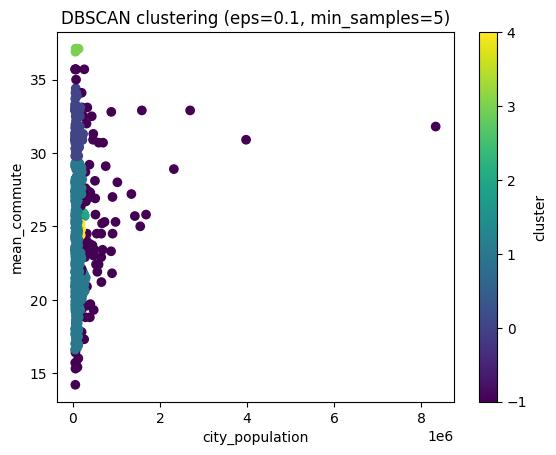

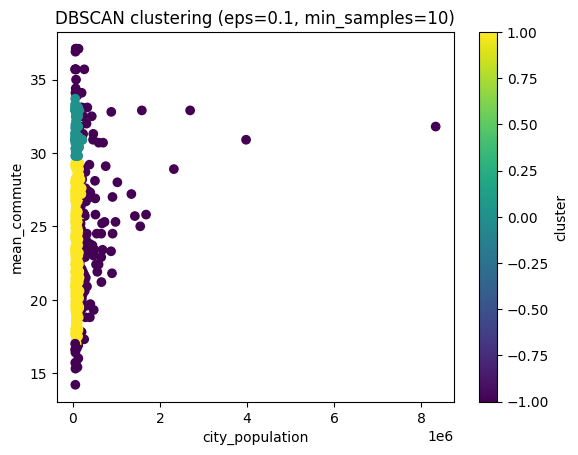

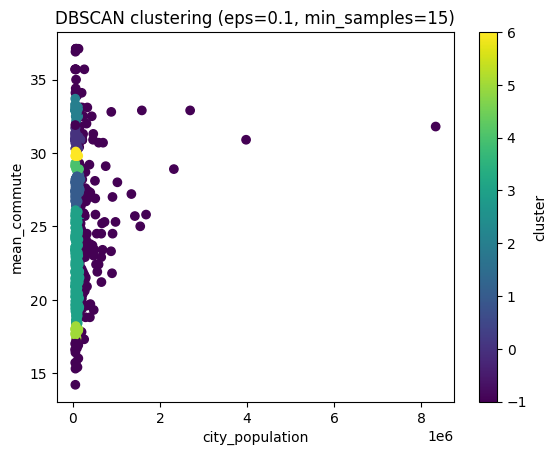

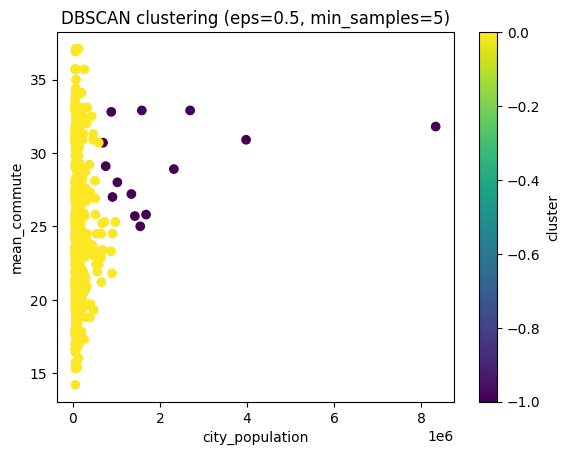

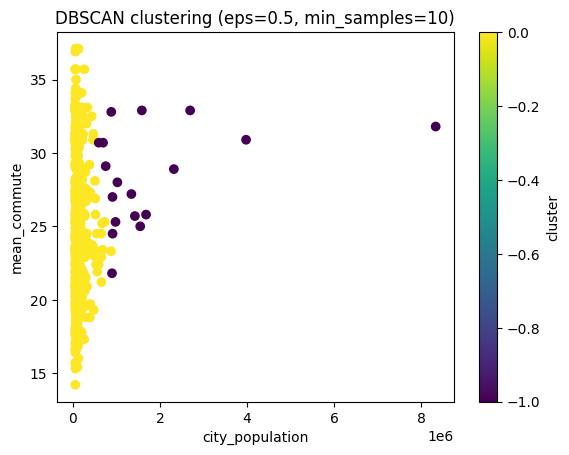

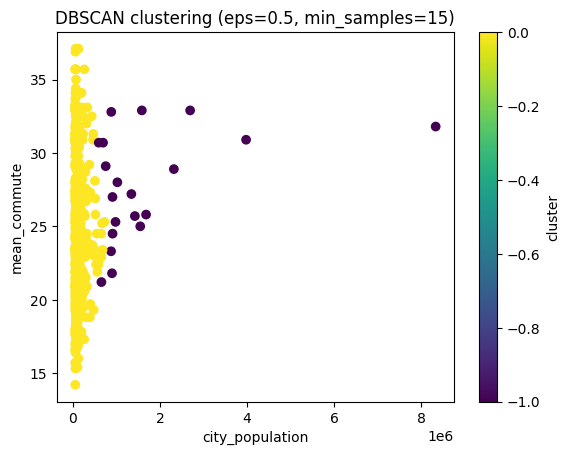

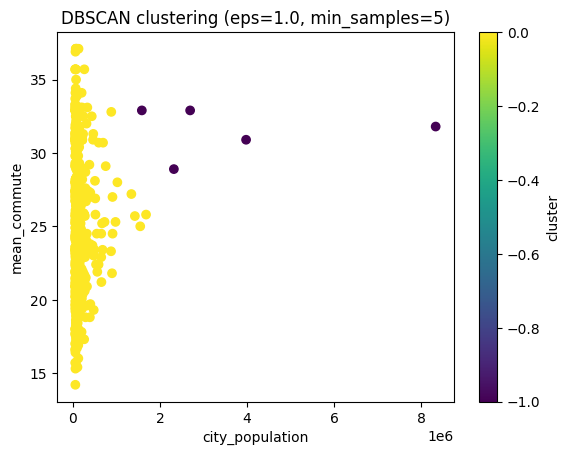

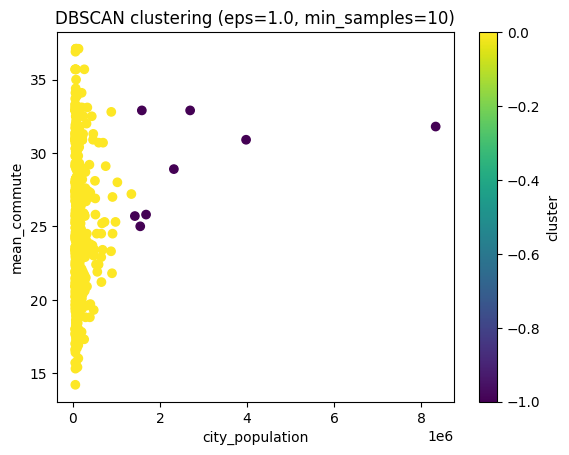

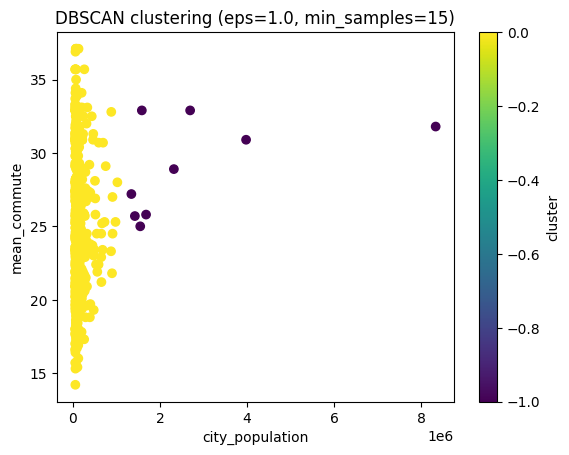

best parameters: eps=1.0, min_samples=5
silhouette score: 0.8545182787331888


In [35]:
features = data[['city_population', 'mean_commute']].values

# standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# grid search params
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_score = -1
best_eps = None
best_min_samples = None
best_clusters = None

# track silhouette score
silhouette_scores = []

# grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        # DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(scaled_features)
        
        # apply labels to clusters
        unique_labels = set(clusters)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        
        # get silhouette score
        score = silhouette_score(scaled_features, clusters)
        silhouette_scores.append(score)
        
        # update best score & parameters
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples
            best_clusters = clusters
        
        # plot ze clusters
        plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis')
        plt.xlabel('city_population')
        plt.ylabel('mean_commute')
        plt.title(f'DBSCAN clustering (eps={eps}, min_samples={min_samples})')
        plt.colorbar(label='cluster')
        plt.show()

# print results
print(f'best parameters: eps={best_eps}, min_samples={best_min_samples}')
print(f'silhouette score: {best_score}')

#### Silhouette score: using features city_population, percent_white

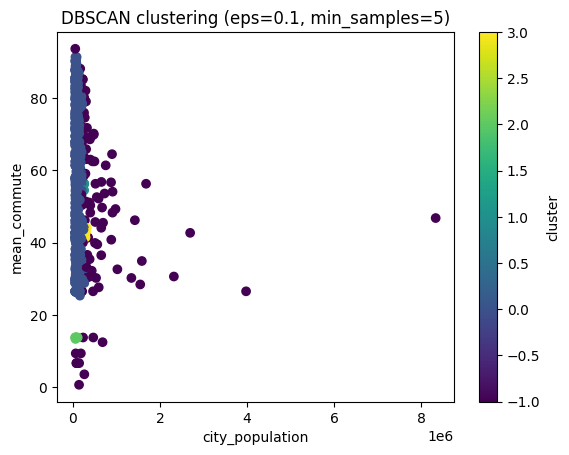

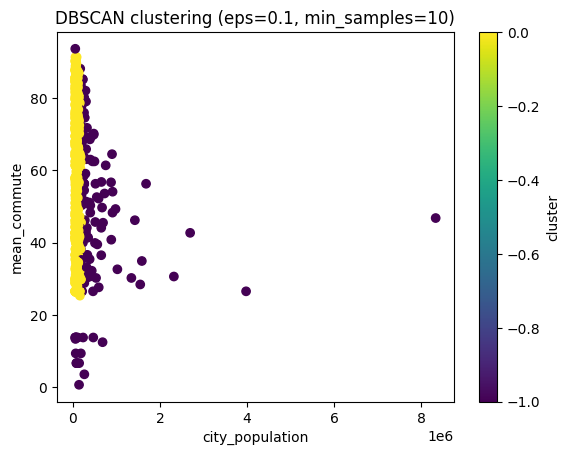

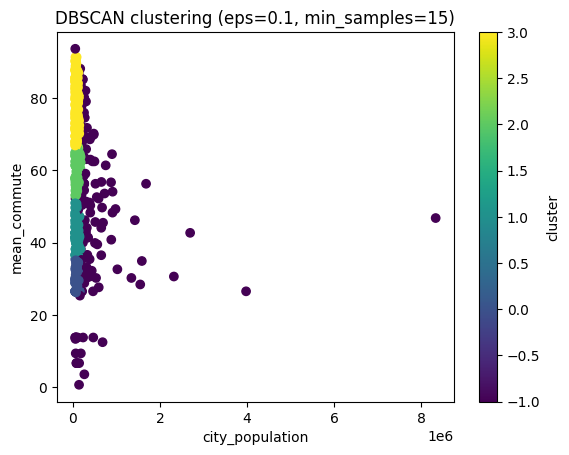

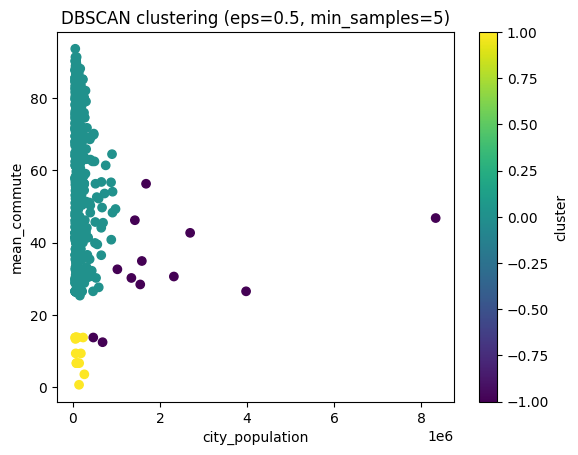

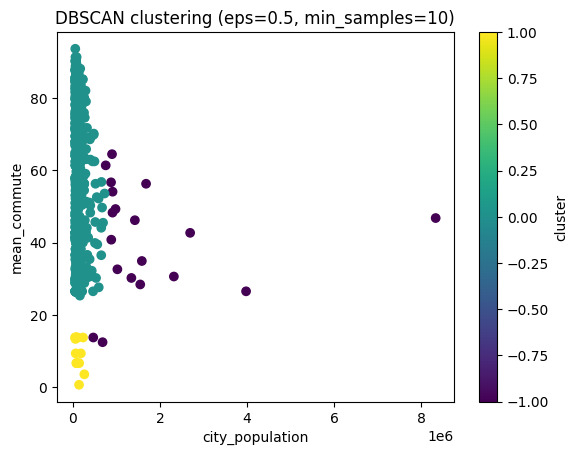

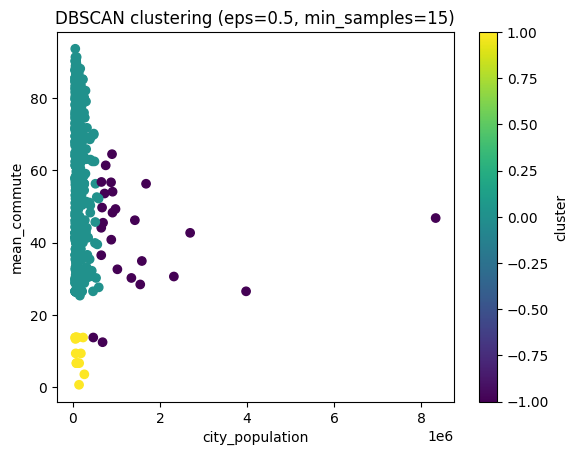

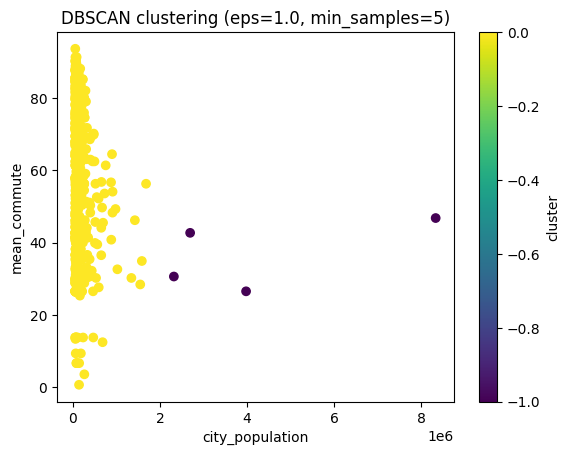

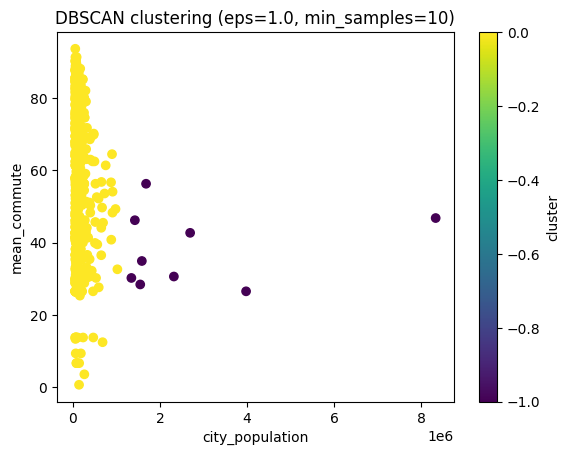

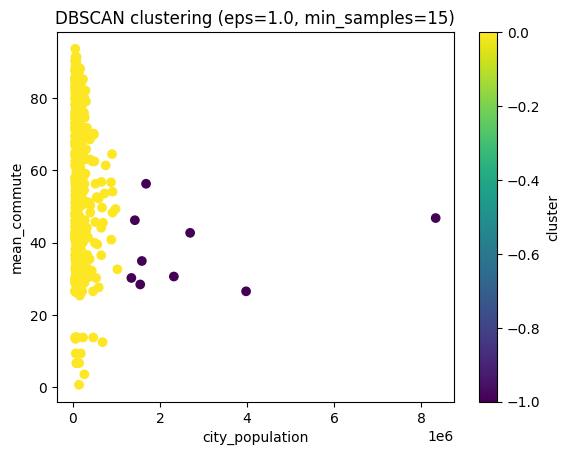

best parameters: eps=1.0, min_samples=5
silhouette score: 0.872090112411566


In [36]:
features = data[['city_population', 'pct_white']].values

# standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# grid search parameters
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_score = -1
best_eps = None
best_min_samples = None
best_clusters = None

# track silhouette score & best parameters
silhouette_scores = []

# DO grid search
for eps in eps_values:
    for min_samples in min_samples_values:

        # DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(scaled_features)
        
        # label clusters
        unique_labels = set(clusters)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        
        # get silhouette score
        score = silhouette_score(scaled_features, clusters)
        silhouette_scores.append(score)
        
        # update best score and parameters
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples
            best_clusters = clusters
        
        # plot! clusters
        plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis')
        plt.xlabel('city_population')
        plt.ylabel('mean_commute')
        plt.title(f'DBSCAN clustering (eps={eps}, min_samples={min_samples})')
        plt.colorbar(label='cluster')
        plt.show()

# print best parameters and silhouette score
print(f'best parameters: eps={best_eps}, min_samples={best_min_samples}')
print(f'silhouette score: {best_score}')

#### Silhouette score: using features crime_rate, avg_property_tax

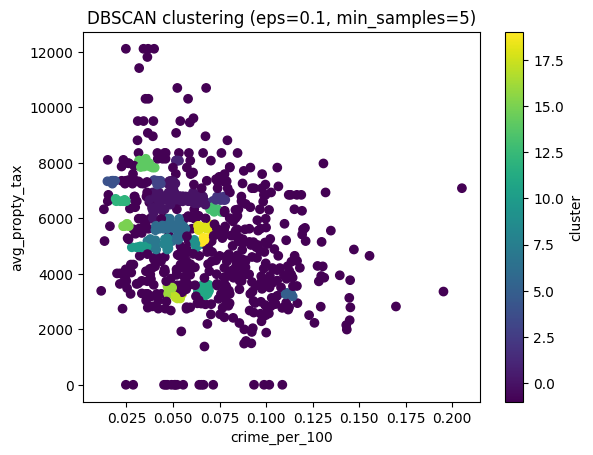

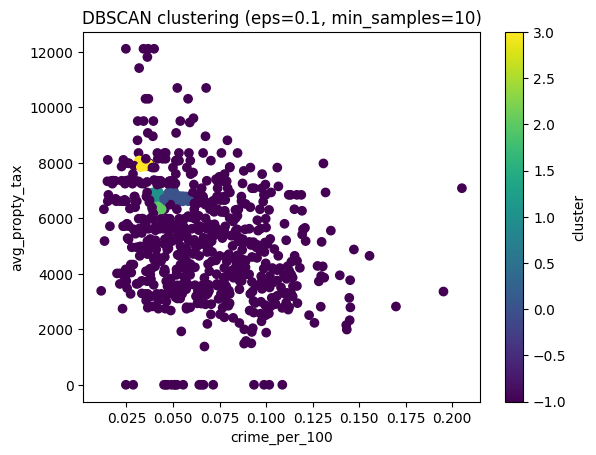

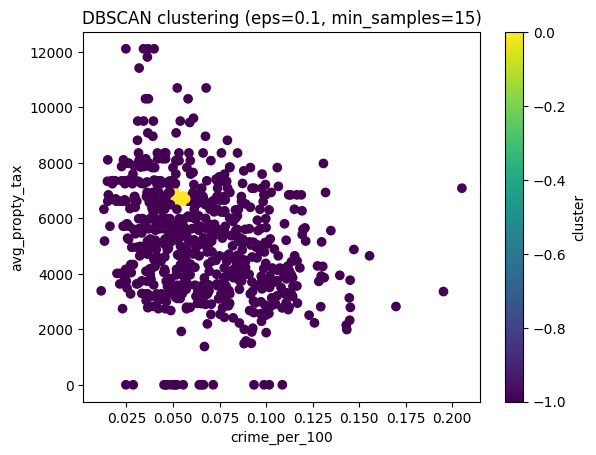

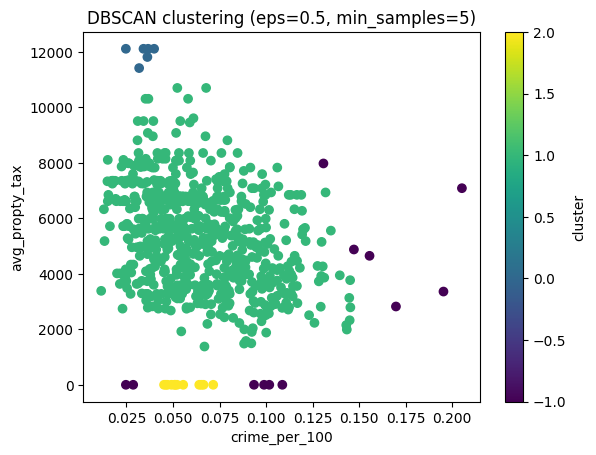

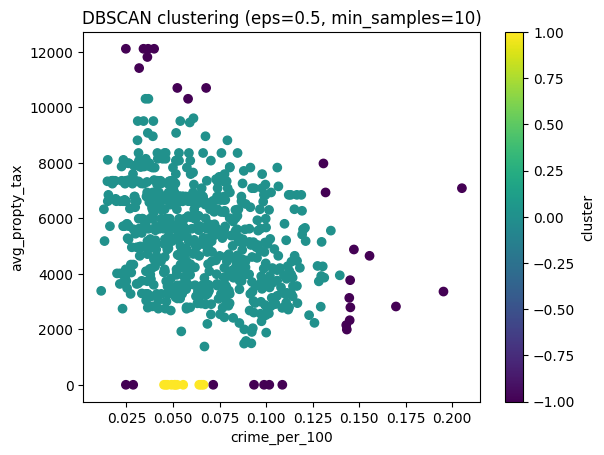

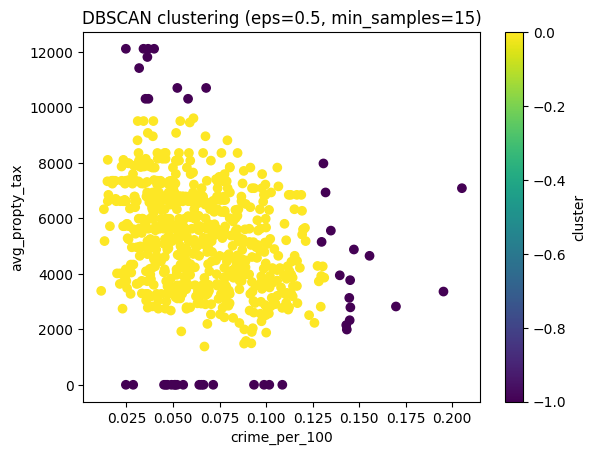

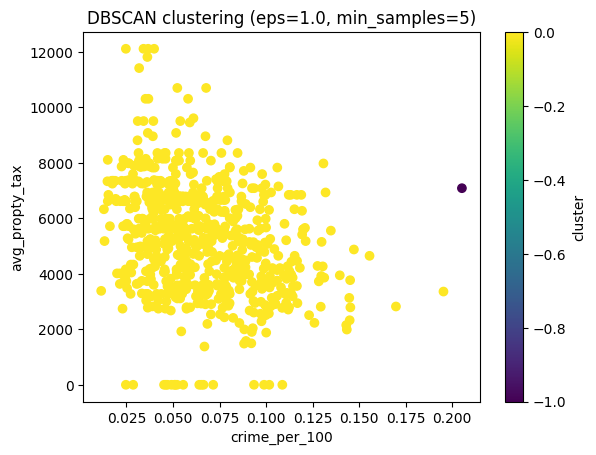

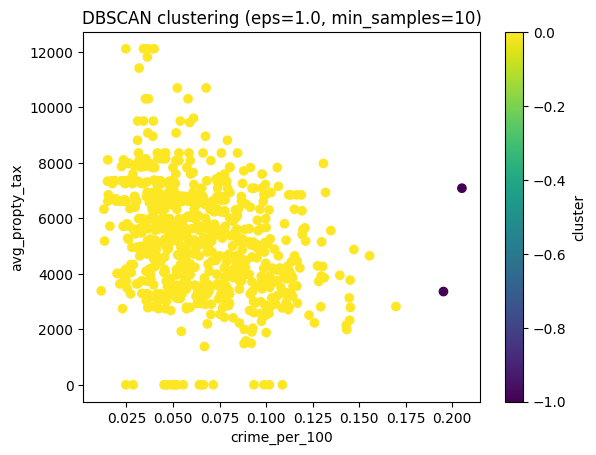

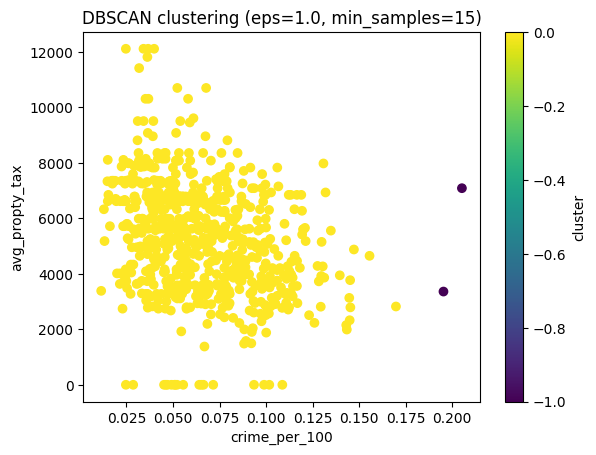

best parameters: eps=1.0, min_samples=5
silhouette score: 0.6308741275864485
all scores: [-0.31248023747495857, -0.18826372929722632, -0.19632669746849538, 0.2988250393258001, 0.37162555345907233, 0.45599595049754227, 0.6308741275864485, 0.6174542190466663, 0.6174542190466663]


In [37]:
features = data[['crime_per_100', 'avg_propty_tax']].values

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_score = -1
best_eps = None
best_min_samples = None
best_clusters = None

# track silhouette score and best parameters
silhouette_scores = []

# perform grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        # DBSCAN clustering!
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(scaled_features)
        
        # label clusters
        unique_labels = set(clusters)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        
        # compute silhouette score
        score = silhouette_score(scaled_features, clusters)
        silhouette_scores.append(score)
        
        # update best score and parameters
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples
            best_clusters = clusters
        
        # plot ze clusters
        plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis')
        plt.xlabel('crime_per_100')
        plt.ylabel('avg_propty_tax')
        plt.title(f'DBSCAN clustering (eps={eps}, min_samples={min_samples})')
        plt.colorbar(label='cluster')
        plt.show()

# print best parameters and silhouette score
print(f'best parameters: eps={best_eps}, min_samples={best_min_samples}')
print(f'silhouette score: {best_score}')
print(f'all scores: {silhouette_scores}')

#### Silhouette score: using features democratic_percentage, republican_percentage

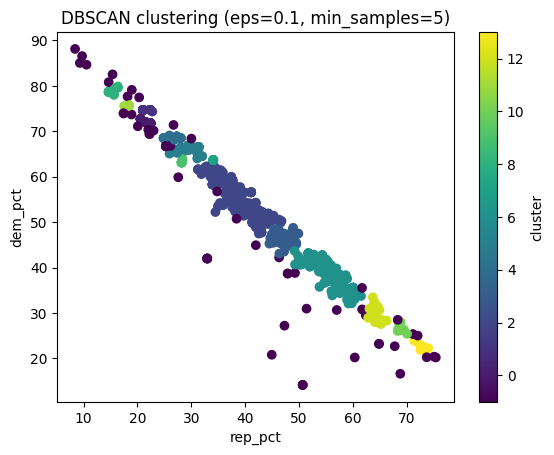

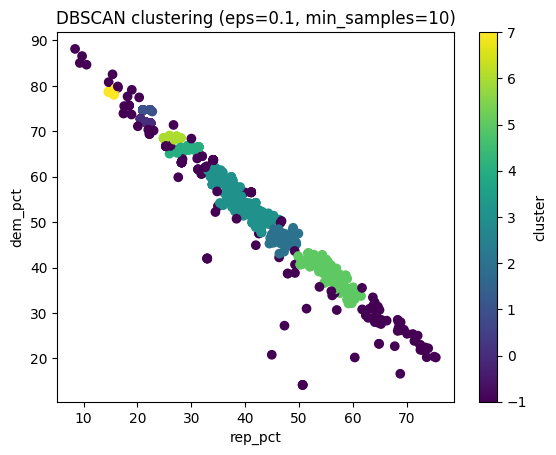

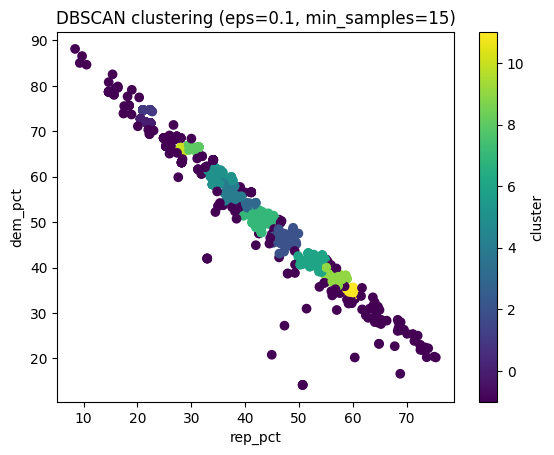

number of clusters: 1
best parameters: eps=0.1, min_samples=5
silhouette score: 0.2852802115953914
all scores: [0.2852802115953914, 0.23714700046650247, 0.12611862680993863]


In [38]:
features = data[['rep_pct', 'dem_pct']].values

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_score = -1
best_eps = None
best_min_samples = None
best_clusters = None

# track silhouette score and best parameters
silhouette_scores = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # DO DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(scaled_features)
        
        # label clusters
        unique_labels = set(clusters)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        if num_clusters < 2:
            continue
        
        # compute silhouette score
        score = silhouette_score(scaled_features, clusters)
        silhouette_scores.append(score)
        
        # update best score and parameters
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples
            best_clusters = clusters
        
        # plot ze clusters
        plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis')
        plt.xlabel('rep_pct')
        plt.ylabel('dem_pct')
        plt.title(f'DBSCAN clustering (eps={eps}, min_samples={min_samples})')
        plt.colorbar(label='cluster')
        plt.show()

# print res
unique_labels = set(clusters)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
print(f'number of clusters: {num_clusters}')
print(f'best parameters: eps={best_eps}, min_samples={best_min_samples}')
print(f'silhouette score: {best_score}')
print(f'all scores: {silhouette_scores}')

#### Silhouette score: using all features

In [41]:
features = data[['city_population', 'county_population', 'density', 'pct_men', 'pct_women', 'pct_hispanic', 'pct_white', 'pct_black', 'pct_native', 'pct_asian', 'pct_pacific', 'pct_unemployed', 'pct_professional', 'pct_service', 'pct_office', 'pct_construction', 'pct_production', 'pct_drive', 'pct_carpool', 'pct_transit', 'pct_walk', 'pct_other_transportation', 'pct_work_at_home', 'pct_private_work', 'pct_public_work', 'pct_self_employed', 'pct_family_work', 'avg_income', 'income_error', 'income_per_cap', 'income_per_cap_err', 'mean_commute', 'covid_cases_per_100k', 'LTM_mean_temp', 'LTM_mean_percipitation', 'LTM_min_temp', 'LTM_max_temp', 'age29andunder_pct', 'age65andolder_pct', 'rural_pct', 'ruralurban_cc', 'rep_pct', 'dem_pct', 'crime_per_100', 'avg_propty_tax']].values

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_score = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        # do DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(scaled_features)
        if len(set(clusters)) < 2:
            continue
        
        # compute silhouette score
        score = silhouette_score(scaled_features, clusters)
        
        # update best score and parameters
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples

# print best silhouette score and parameters
print(f'best silhouette score: {best_score}')
print(f'best parameters: eps={best_eps}, min_samples={best_min_samples}')


best silhouette score: -0.014171876683409872
best parameters: eps=0.5, min_samples=10


#### Silhouette score: using pairs of all features

best silhouette score: 0.9572919913674185
best parameters: eps=0.01, min_samples=5
best feature pair: [ 0.65345379 -0.70986771], [ 0.65345379 -0.70986771]
number of clusters: 10


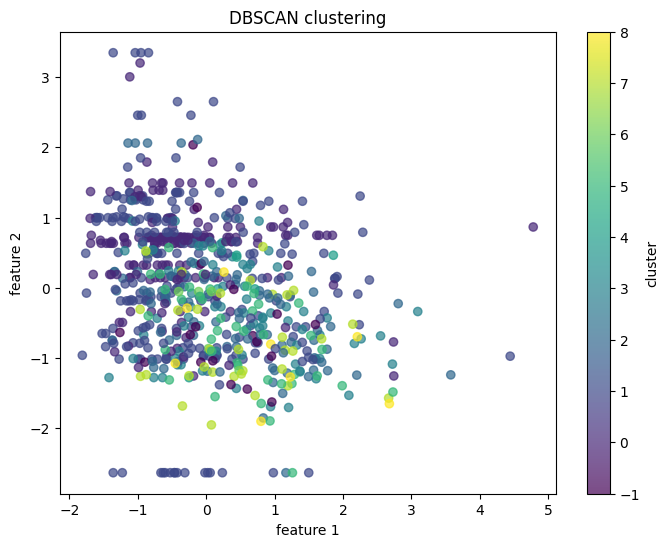

In [4]:
features = data[['city_population', 'county_population', 'density', 'pct_men', 'pct_women', 'pct_hispanic', 'pct_white', 'pct_black', 'pct_native', 'pct_asian', 'pct_pacific', 'pct_unemployed', 'pct_professional', 'pct_service', 'pct_office', 'pct_construction', 'pct_production', 'pct_drive', 'pct_carpool', 'pct_transit', 'pct_walk', 'pct_other_transportation', 'pct_work_at_home', 'pct_private_work', 'pct_public_work', 'pct_self_employed', 'pct_family_work', 'avg_income', 'income_error', 'income_per_cap', 'income_per_cap_err', 'mean_commute', 'covid_cases_per_100k', 'LTM_mean_temp', 'LTM_mean_percipitation', 'LTM_min_temp', 'LTM_max_temp', 'age29andunder_pct', 'age65andolder_pct', 'rural_pct', 'ruralurban_cc', 'rep_pct', 'dem_pct', 'crime_per_100', 'avg_propty_tax']].values

# load in original data as csv file
cities = []
og_csv = "data/clean_proj_data.csv"
with open(og_csv, 'r', newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        cities.append(row[1])


# standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# define range of values
eps_values = [.01, 0.1, 0.5, 1.0, 1.5]
min_samples_values = [5, 10, 15, 20]

best_score = -1
best_eps = None
best_min_samples = None

# grid search
for i in range(len(features[0])-1):
    for j in range(i+1, len(features[0])):
        # sel pair of features
        pair_features = scaled_features[:, [i, j]]
        
        # do DBSCAN clustering
        for eps in eps_values:
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                clusters = dbscan.fit_predict(pair_features)
                if len(set(clusters)) < 2:
                    continue
                
                # compute silhouette score
                score = silhouette_score(pair_features, clusters)
                
                # update best score and parameters
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples
                    best_clusters = clusters
                    # map feature to city
                    best_features = pair_features

# output results
print(f'best silhouette score: {best_score}')
print(f'best parameters: eps={best_eps}, min_samples={best_min_samples}')
print(f'best feature pair: {best_features[0]}, {best_features[1]}')
print(f'number of clusters: {len(set(best_clusters))}')

# visualize -> plot the clusters
x = scaled_features[:, i]
y = scaled_features[:, j]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=best_clusters, cmap='viridis', alpha=0.7)
plt.title('DBSCAN clustering')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.colorbar(label='cluster')
plt.show()


##### Get number of features

In [45]:
print(len([
    "index", "city_population", "county_population", "density", "pct_men", "pct_women",
    "pct_hispanic", "pct_white", "pct_black", "pct_native", "pct_asian", "pct_pacific",
    "pct_unemployed", "pct_professional", "pct_service", "pct_office", "pct_construction",
    "pct_production", "pct_drive", "pct_carpool", "pct_transit", "pct_walk", "pct_other_transportation",
    "pct_work_at_home", "pct_private_work", "pct_public_work", "pct_self_employed", "pct_family_work",
    "avg_income", "income_error", "income_per_cap", "income_per_cap_err", "mean_commute", "covid_cases_per_100k",
    "LTM_mean_temp", "LTM_mean_percipitation", "LTM_min_temp", "LTM_max_temp", "age29andunder_pct",
    "age65andolder_pct", "rural_pct", "ruralurban_cc", "rep_pct", "dem_pct", "crime_per_100", "avg_propty_tax"
]))


46


#### Silhouette score and  Davies-Bouldin index: using pairs of all features

best silhouette score: 0.8512573431954619
best Davies-Bouldin index: 0.13176612933304682
best parameters: eps=1.0, min_samples=5
best features: (3, 4)


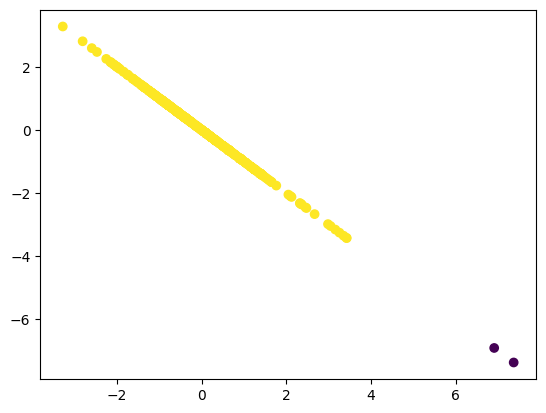

In [46]:
features = data[['city_population', 'county_population', 'density', 'pct_men', 'pct_women', 'pct_hispanic', 'pct_white', 'pct_black', 'pct_native', 'pct_asian', 'pct_pacific', 'pct_unemployed', 'pct_professional', 'pct_service', 'pct_office', 'pct_construction', 'pct_production', 'pct_drive', 'pct_carpool', 'pct_transit', 'pct_walk', 'pct_other_transportation', 'pct_work_at_home', 'pct_private_work', 'pct_public_work', 'pct_self_employed', 'pct_family_work', 'avg_income', 'income_error', 'income_per_cap', 'income_per_cap_err', 'mean_commute', 'covid_cases_per_100k', 'LTM_mean_temp', 'LTM_mean_percipitation', 'LTM_min_temp', 'LTM_max_temp', 'age29andunder_pct', 'age65andolder_pct', 'rural_pct', 'ruralurban_cc', 'rep_pct', 'dem_pct', 'crime_per_100', 'avg_propty_tax']].values

# standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# define vals
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_score = -1
best_combined_score = -1
best_eps = None
best_min_samples = None
best_db_score = None

# do grid search for each pair of features
for i in range(len(features[0])-1):
    for j in range(i+1, len(features[0])):

        # select pair of features
        pair_features = scaled_features[:, [i, j]]
        
        # do DBSCAN clustering
        for eps in eps_values:
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                clusters = dbscan.fit_predict(pair_features)
                if len(set(clusters)) < 2:
                    continue
                
                # compute silhouette score
                score = silhouette_score(pair_features, clusters)
                # compute Davies-Bouldin index
                db_idx = davies_bouldin_score(pair_features, clusters)
                
                # compute combined score
                combined_score = score / db_idx
                
                # update best score and parameters
                if combined_score > best_combined_score:
                    best_combined_score = combined_score
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples
                    best_clusters = clusters
                    best_features = (i, j)
                    best_db_score = db_idx

# print best silhouette score, Davies-Bouldin index, and parameters
print(f'best silhouette score: {best_score}')
print(f'best Davies-Bouldin index: {best_db_score}')
print(f'best parameters: eps={best_eps}, min_samples={best_min_samples}')
print(f'best features: {best_features}')

# print best feature DBSCAN clustering
plt.scatter(scaled_features[:, best_features[0]], scaled_features[:, best_features[1]], c=best_clusters, cmap='viridis')


#### Davies-Bouldin index: using pairs of all features

In [47]:
features = data[['city_population', 'county_population', 'density', 'pct_men', 'pct_women', 'pct_hispanic', 'pct_white', 'pct_black', 'pct_native', 'pct_asian', 'pct_pacific', 'pct_unemployed', 'pct_professional', 'pct_service', 'pct_office', 'pct_construction', 'pct_production', 'pct_drive', 'pct_carpool', 'pct_transit', 'pct_walk', 'pct_other_transportation', 'pct_work_at_home', 'pct_private_work', 'pct_public_work', 'pct_self_employed', 'pct_family_work', 'avg_income', 'income_error', 'income_per_cap', 'income_per_cap_err', 'mean_commute', 'covid_cases_per_100k', 'LTM_mean_temp', 'LTM_mean_percipitation', 'LTM_min_temp', 'LTM_max_temp', 'age29andunder_pct', 'age65andolder_pct', 'rural_pct', 'ruralurban_cc', 'rep_pct', 'dem_pct', 'crime_per_100', 'avg_propty_tax']].values

# standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
print(scaled_features)
# define range of values for eps and min_samples
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_score = float('-inf')
best_eps = None
best_min_samples = None
best_clusters = None

for i in range(len(scaled_features[0])-1):
    for j in range(i+1, len(scaled_features[0])):

        # select pair of features
        pair_features = scaled_features[:, [i, j]]

    # do grid search
    for eps in eps_values:
        for min_samples in min_samples_values:
            # perform DBSCAN clustering
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(pair_features)
            if len(set(clusters)) < 2:
                continue
            
            # compute Davies-Bouldin score
            db_score = davies_bouldin_score(pair_features, clusters)
            
            # update best score and parameters
            if db_score > best_score:
                best_score = db_score
                best_eps = eps
                best_min_samples = min_samples
                best_clusters = clusters

# print best Davies-Bouldin score and parameters
print(f'best Davies-Bouldin score: {best_score}')
print(f'best parameters: eps={best_eps}, min_samples={best_min_samples}')
# output best feature names
print(f'best features: {data.columns[best_features[0]]}, {data.columns[best_features[1]]}')
print(f'number of clusters: {len(set(best_clusters))}') 


[[20.20534467  0.02917395  5.38978904 ...  2.31084138 -0.96476621
   3.19932807]
 [ 9.42890714  3.66921642  0.97139956 ...  1.28411381 -0.36676076
   0.71683284]
 [ 0.7307033   3.66921642  1.11810506 ...  1.28411381  0.05221149
   0.71683284]
 ...
 [-0.28753087 -0.63207308 -0.66849469 ... -2.17636134  2.67823575
  -1.64863133]
 [-0.29059025 -0.65623467 -0.82054574 ... -2.28896256  0.36395813
  -1.37681515]
 [-0.29838585 -0.60222479 -0.63582748 ... -1.10354485  2.73056929
  -1.48278382]]
best Davies-Bouldin score: 8.257135940376022
best parameters: eps=0.5, min_samples=10
best features: pct_men, pct_women
number of clusters: 4


#### Calinski-Harabasz index: using pairs of all features

In [48]:
features = data[['city_population', 'county_population', 'density', 'pct_men', 'pct_women', 'pct_hispanic', 'pct_white', 'pct_black', 'pct_native', 'pct_asian', 'pct_pacific', 'pct_unemployed', 'pct_professional', 'pct_service', 'pct_office', 'pct_construction', 'pct_production', 'pct_drive', 'pct_carpool', 'pct_transit', 'pct_walk', 'pct_other_transportation', 'pct_work_at_home', 'pct_private_work', 'pct_public_work', 'pct_self_employed', 'pct_family_work', 'avg_income', 'income_error', 'income_per_cap', 'income_per_cap_err', 'mean_commute', 'covid_cases_per_100k', 'LTM_mean_temp', 'LTM_mean_percipitation', 'LTM_min_temp', 'LTM_max_temp', 'age29andunder_pct', 'age65andolder_pct', 'rural_pct', 'ruralurban_cc', 'rep_pct', 'dem_pct', 'crime_per_100', 'avg_propty_tax']].values

# standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# def range of values for eps and min_samples
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_score = float('-inf')
best_eps = None
best_min_samples = None
best_clusters = None

# do grid search!!
for i in range(len(scaled_features[0])-1):
    for j in range(i+1, len(scaled_features[0])): 
        for eps in eps_values:
            for min_samples in min_samples_values:
                # do DBSCAN clustering
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                clusters = dbscan.fit_predict(scaled_features)
                if len(set(clusters)) < 2:
                    continue
                
                # get Calinski-Harabasz Index
                ch_score = calinski_harabasz_score(scaled_features, clusters)
                
                # update best score and parameters
                if ch_score > best_score:
                    best_score = ch_score
                    best_eps = eps
                    best_min_samples = min_samples
                    best_clusters = clusters

# print BEST Calinski-Harabasz Index & parameters:D
print(f'Calinski-Harabasz Index: {best_score}')
print(f'parameters: eps={best_eps}, min_samples={best_min_samples}')
print(f'feature names: {data.columns[best_features[0]]}, {data.columns[best_features[1]]}')
print(f'clusters: {len(set(best_clusters))}')

# print number of clusters in best scan
unique_labels = set(best_clusters)

Calinski-Harabasz Index: 20.96274875666885
parameters: eps=1.0, min_samples=15
feature names: pct_men, pct_women
clusters: 3


#### Calculate gap statistic to find optimal number of clusters

In [49]:
# load data
csv_data = np.loadtxt("data/numerical_data.csv", delimiter=",", skiprows=1)

# define the range of vals for k
k_values = range(2, 10)

# compute gap statistic for each k
gap_values = []
for k in k_values:
    # fits KMeans clustering model
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    
    # compute within-cluster dispersion
    within_dispersion = kmeans.inertia_
    
    # generate reference data
    reference_data = np.random.uniform(low=np.min(data, axis=0), high=np.max(data, axis=0), size=(data.shape[0], data.shape[1]))
    
    # fit KMeans clustering model on reference data
    reference_kmeans = KMeans(n_clusters=k)
    reference_kmeans.fit(reference_data)
    
    # compute within-cluster dispersion for reference data
    reference_within_dispersion = reference_kmeans.inertia_
    
    # compute gap statistic
    gap = np.log(reference_within_dispersion) - np.log(within_dispersion)
    
    # append gap value to list
    gap_values.append(gap)

# find the optimal number of clusters
optimal_k = np.argmax(gap_values) + 2

# print the optimal number
print(f'optimal number of clusters: {optimal_k}')

# find the optimal num of clusters
optimal_k = np.argmax(gap_values) + 2

# print the optimal number
print(f'optimal # of clusters: {optimal_k}')

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

optimal number of clusters: 9
optimal # of clusters: 9


#### SSE and silhouette score: using pairs of all features


best SSE: 982977.0618709673
best parameters: eps=0.5, min_samples=5
best feature pair: LTM_mean_temp, rep_pct
number of clusters: 2


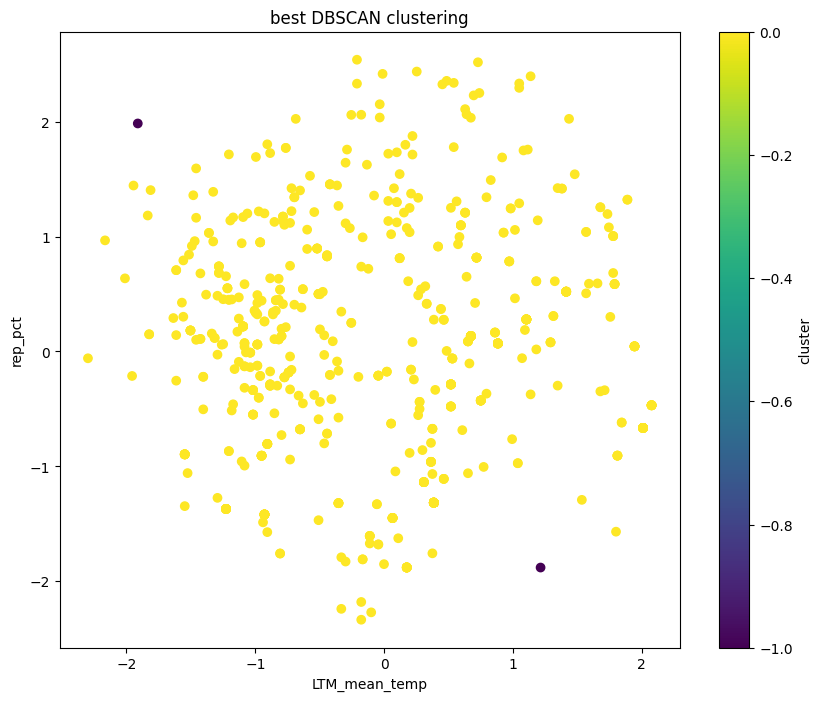

In [50]:
features = data[['city_population', 'county_population', 'density', 'pct_men', 'pct_women', 'pct_hispanic', 'pct_white', 'pct_black', 'pct_native', 'pct_asian', 'pct_pacific', 'pct_unemployed', 'pct_professional', 'pct_service', 'pct_office', 'pct_construction', 'pct_production', 'pct_drive', 'pct_carpool', 'pct_transit', 'pct_walk', 'pct_other_transportation', 'pct_work_at_home', 'pct_private_work', 'pct_public_work', 'pct_self_employed', 'pct_family_work', 'avg_income', 'income_error', 'income_per_cap', 'income_per_cap_err', 'mean_commute', 'covid_cases_per_100k', 'LTM_mean_temp', 'LTM_mean_percipitation', 'LTM_min_temp', 'LTM_max_temp', 'age29andunder_pct', 'age65andolder_pct', 'rural_pct', 'ruralurban_cc', 'rep_pct', 'dem_pct', 'crime_per_100', 'avg_propty_tax']].values

# standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# define range of values
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_sse = float('inf')
best_eps = None
best_min_samples = None

# grid search
for i in range(len(features[0])-1):
    for j in range(i+1, len(features[0])):
        # select pair of features
        pair_features = scaled_features[:, [i, j]]
        
        # perform DBSCAN clustering
        for eps in eps_values:
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                clusters = dbscan.fit_predict(pair_features)
                
                if len(set(clusters)) < 2:
                    continue
                
                # compute SSE
                cluster_centers = []
                for cluster_label in set(clusters):
                    cluster_points = pair_features[clusters == cluster_label]
                    cluster_center = cluster_points.mean(axis=0)
                    cluster_centers.append(cluster_center)
                
                sse = sum(((pair_features - cluster_centers[cluster_label])**2).sum() for cluster_label in clusters)
                
                # update best SSE and parameters
                if sse < best_sse:
                    best_sse = sse
                    best_eps = eps
                    best_min_samples = min_samples
                    best_clusters = clusters
                    best_features = (i, j)

# output results
print(f'best SSE: {best_sse}')
print(f'best parameters: eps={best_eps}, min_samples={best_min_samples}')
print(f'best feature pair: {data.columns[best_features[0]]}, {data.columns[best_features[1]]}')
print(f'number of clusters: {len(set(best_clusters))}')

plt.figure(figsize=(10, 8))
plt.scatter(scaled_features[:, best_features[0]], scaled_features[:, best_features[1]], c=best_clusters, cmap='viridis')
plt.colorbar(label='cluster')
plt.xlabel(data.columns[best_features[0]])
plt.ylabel(data.columns[best_features[1]])
plt.title('best DBSCAN clustering')
plt.show()

#### Beta CV: using pairs of all features

best betaCV: -0.22067055725579318 (silhouette = -0.30129512900366745, CH index = 1.3653617081975156)
best parameters: eps=0.1, min_samples=15
best feature pair: age29andunder_pct, crime_per_100
number of clusters: 2


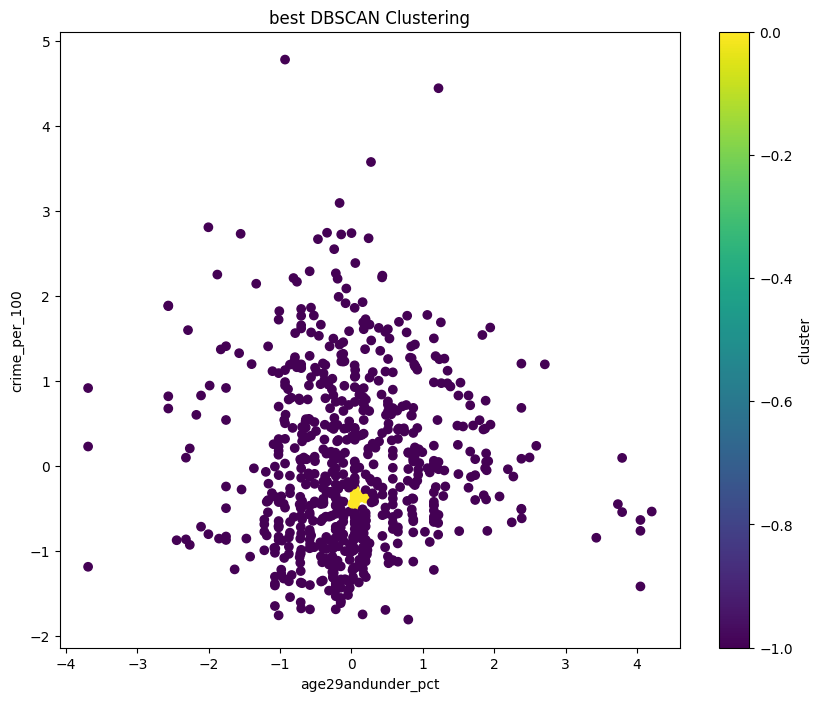

In [51]:
features = data[['city_population', 'county_population', 'density', 'pct_men', 'pct_women', 'pct_hispanic', 'pct_white', 'pct_black', 'pct_native', 'pct_asian', 'pct_pacific', 'pct_unemployed', 'pct_professional', 'pct_service', 'pct_office', 'pct_construction', 'pct_production', 'pct_drive', 'pct_carpool', 'pct_transit', 'pct_walk', 'pct_other_transportation', 'pct_work_at_home', 'pct_private_work', 'pct_public_work', 'pct_self_employed', 'pct_family_work', 'avg_income', 'income_error', 'income_per_cap', 'income_per_cap_err', 'mean_commute', 'covid_cases_per_100k', 'LTM_mean_temp', 'LTM_mean_percipitation', 'LTM_min_temp', 'LTM_max_temp', 'age29andunder_pct', 'age65andolder_pct', 'rural_pct', 'ruralurban_cc', 'rep_pct', 'dem_pct', 'crime_per_100', 'avg_propty_tax']].values

# standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# define range of values
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 15]

best_beta_cv = float('inf')
best_ch_index = float('-inf')
best_sscore = float('-inf')
best_eps = None
best_min_samples = None

# grid search
for i in range(len(features[0])-1):
    for j in range(i+1, len(features[0])):
        # select pair of features
        pair_features = scaled_features[:, [i, j]]
        
        # perform DBSCAN clustering
        for eps in eps_values:
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                clusters = dbscan.fit_predict(pair_features)
                
                if len(set(clusters)) < 2:
                    continue
                
                # compute silhouette
                silhouette = silhouette_score(pair_features, clusters)

                # compute CH index
                ch_index = calinski_harabasz_score(pair_features, clusters)

                # compute beta cv
                beta_cv = silhouette / ch_index

                # update best beta cv and parameters
                if beta_cv < best_beta_cv:
                    best_beta_cv = beta_cv
                    best_sscore = silhouette
                    best_ch_index = ch_index
                    best_eps = eps
                    best_min_samples = min_samples
                    best_clusters = clusters
                    best_features = (i, j)

# output results
print(f'best betaCV: {best_beta_cv} (silhouette = {best_sscore}, CH index = {best_ch_index})')
print(f'best parameters: eps={best_eps}, min_samples={best_min_samples}')
print(f'best feature pair: {data.columns[best_features[0]]}, {data.columns[best_features[1]]}')
print(f'number of clusters: {len(set(best_clusters))}')

plt.figure(figsize=(10, 8))
plt.scatter(scaled_features[:, best_features[0]], scaled_features[:, best_features[1]], c=best_clusters, cmap='viridis')
plt.colorbar(label='cluster')
plt.xlabel(data.columns[best_features[0]])
plt.ylabel(data.columns[best_features[1]])
plt.title('best DBSCAN Clustering')
plt.show()